<a href="https://colab.research.google.com/github/PUC-RecSys-Class/RecSysPUC-2020/blob/master/practicos/pyRecLab_MostPopular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Práctica de Sistemas Recomendadores: pyreclab - Most popular e Item average rating. 

En este práctico vamos a utilizar la biblioteca de Python [pyreclab](https://github.com/gasevi/pyreclab), desarrollado por los Laboratorios IALab y SocVis de la Pontificia Universidad Católica de Chile para recomendación no personalizada: **Most Popular** e **Item Average Rating**.




In [1]:
import pandas as pd
import pyreclab
import seaborn as sns
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style="whitegrid")

## Antes de recomendar
Los archivos `u2.base` y `u2.test` tienen tuplas (usuario, item, rating, timestamp), que es la información de preferencias de usuarios sobre películas en una muestra del dataset [MovieLens](https://grouplens.org/datasets/movielens/). Revisemos cómo es uno de estos archivos y luego haremos gráficos que nos permitan sacar conclusiones a partir del mismo.

In [4]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base', sep='\t', names=['userid', 'itemid', 'rating', 'timestamp'], header=None)
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,4,878542960
1,1,4,3,876893119
2,1,5,3,889751712
3,1,6,5,887431973
4,1,7,4,875071561


In [5]:
# Ahora queremos realizar una observación rápida de los ratings
df_train.describe()[['rating']]

,rating
count,80000.000000
mean,3.526463
std,1.124429
min,1.000000
25%,3.000000
50%,4.000000
75%,4.000000
max,5.000000


Por otra parte, para obtener información adicional de cada película tal como **título**, **fecha de lanzamiento**, **género**, etc., cargaremos el archivo de items descargado (`u.item`) para poder mapear cada identificador de ítem al conjunto de datos que lo describe. Revisemos el contenido de este archivo

In [6]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [7]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None,
                        encoding='latin-1')
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Distribución de peliculas por género:

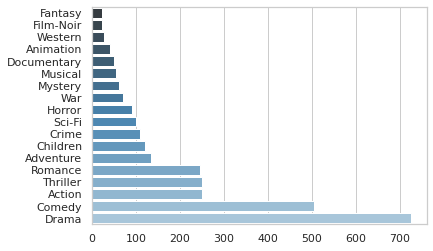

In [8]:
genre_columns = ['Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

genre_count = df_items[genre_columns].sum().sort_values()

sns.barplot(x=genre_count.values, y=genre_count.index, label="Total", palette="Blues_d")

**Pregunta:** Explique cómo funciona most popular y average rating. 
¿Qué problemas podría encontrar al utilizar cada uno de ellos?. 

**Respuesta:**

**Most Popular** funciona contando la cantidad de interacciones con usuarios distintos que tienen los items del dataset, para luego recomendar aquellos que hayan sido consumidos por la mayor cantidad de usuarios. Un problema de Most Popular es que el hecho de que un ítem sea popular no necesariamente significa que sea de gran calidad, o que le vaya a gustar a todos los usuarios. Otro problema es que el sistema queda sesgado y no recomienda los items que son poco conocidos, fallando en entregar 'novedades' a los usuarios.

**Average Rating** funciona promediando los ratings que los usuarios entregan a cada ítem, para luego recomendar aquellos que posean la mejor calificación promedio. Esta técnica falla cuando un ítem tiene pocos ratings, ya que queda muy sesgado en función de los pocos usuarios que lo calificaron (por ejemplo un ítem que sólo ha sido calificado por 2 usuarios de forma positiva queda con un rating promedio del 100%).

## Most popular

In [9]:
# Definicion de objeto "most popular"
most_popular = pyreclab.MostPopular(dataset='u2.base',
                                    dlmchar=b'\t',
                                    header=False,
                                    usercol=0,
                                    itemcol=1,
                                    ratingcol=2)

# en teoria no es "entrenar" , objeto "most_popular" solo registra los items más populares en el set de entrenamiento
most_popular.train()

Calculamos métricas de ranking ($nDCG@10$ y $MAP$) para conocer el rendimiento de nuestro recomendador en el set de test. 

1. nDCG@10: normalized discounted cummulative gain @ 10 

$DCG = \sum{ \frac{2^{rel} -1 }{log_2(i+1)}}$

$nDCG = \frac{DCG}{IDCG}$

$IDCG: $ ideal DCG donde todos los relevantes están en las primeras posiciones. 

$nDCG@10$ es la métrica nDCG para los primeros 10 items recomendados. 

2. MAP: mean average precision 

$AveP = \frac{\sum{P(k) * rel(k)}}{total items relevantes}$

$MAP = \sum{\frac{AveP(u)}{U}}$

donde: 
$P(k):$ precision en posicion k (P@10 or "Precision at 10" corresponde al numero de items relevantes en las primeras 10 posiciones) <br>  
$rel(k): $ 0 si el item no es relevante o 1 si es relevante. <br>

**TIP:** relevante por ejemplo es si es que el usuario le dió más de 3 estrellas de rating a un item. <br>



**Ejemplo**

Sistema me recomendó estas 10 películas: 
[13,15,35, 28, 3, 1, 100, 122]

El usuario en realidad prefirió estas películas: 
[13,90,12, 2, 3, 384, 219, 12938]

Construimos lista asignando un 1 si es relevante o 0 si no: <br> 
[1, 0, 0,0,1,0,0,0]

Sobre esta lista calculamos las métricas nDCG@K y MAP (serán vistas en más detalle en clases). 











In [10]:
# Testing de recomendaciones sobre los primeros 10 items
top_n = 10

recommendList, maprec, ndcg = most_popular.testrec(input_file='u2.test',
                                            dlmchar=b'\t',
                                            header=False,
                                            usercol=0,
                                            itemcol=1,
                                            ratingcol=2,
                                            topn=top_n,
                                            relevance_threshold=2,
                                            includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

MAP: 0.2889129174597905
NDCG@10: 0.1598011823409535


In [17]:
# Calcular las recomendaciones para un usuario en particular (id = 2)
user_id = 2

ranking = [int(r) for r in most_popular.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))

Recommendation for user 2: [50, 100, 258, 181, 294, 286, 288, 1, 300, 174]


In [18]:
# Ver explicitamente las recomendaciones para un usuario determinado
df_items.loc[ranking]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,
50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,...,0,0,0,0,0,1,1,0,1,0
100,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
258,Contact (1997),11-Jul-1997,NaN,http://us.imdb.com/Title?Contact+(1997/I),0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
181,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,0,1,1,0,0,0,...,0,0,0,0,0,1,1,0,1,0
294,Liar Liar (1997),21-Mar-1997,NaN,http://us.imdb.com/Title?Liar+Liar+(1997),0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
286,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
288,Scream (1996),20-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Scream%20(1996),0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
300,Air Force One (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Air+Force+One...,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0



**Pregunta** Cambiar el id de usuario, qué se puede observar de las recomendaciones?




In [19]:
# Calcular las recomendaciones para un usuario en particular (id = 7)
user_id = 7

ranking = [int(r) for r in most_popular.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))

Recommendation for user 7: [50, 258, 181, 121, 300, 174, 127, 7, 98, 172]


In [20]:
# Ver explicitamente las recomendaciones para un usuario determinado
df_items.loc[ranking]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,
50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,...,0,0,0,0,0,1,1,0,1,0
258,Contact (1997),11-Jul-1997,NaN,http://us.imdb.com/Title?Contact+(1997/I),0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
181,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,0,1,1,0,0,0,...,0,0,0,0,0,1,1,0,1,0
121,Independence Day (ID4) (1996),03-Jul-1996,NaN,http://us.imdb.com/M/title-exact?Independence%...,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
300,Air Force One (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Air+Force+One...,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
174,Raiders of the Lost Ark (1981),01-Jan-1981,NaN,http://us.imdb.com/M/title-exact?Raiders%20of%...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
127,"Godfather, The (1972)",01-Jan-1972,NaN,"http://us.imdb.com/M/title-exact?Godfather,%20...",0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
98,"Silence of the Lambs, The (1991)",01-Jan-1991,NaN,http://us.imdb.com/M/title-exact?Silence%20of%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


**Respuesta:** Se observan recomendaciones distintas, pero de películas igual de populares que con el otro usuario. Esto probablemente se debe a un factor aleatorio (por usuario) al momento de elegir películas a recomendar cuando su popularidad es similar.

## Item average rating 

In [21]:
# Definicion de objeto "item average rating"
item_avg = pyreclab.ItemAvg(dataset='u2.base',
                            dlmchar=b'\t',
                            header=False,
                            usercol=0,
                            itemcol=1,
                            ratingcol=2)

# en teoria no es "entrenar" , objeto "item_average" solo registra los items con mayor rating promedio en el set de entrenamiento
item_avg.train()

In [22]:
# Testing de recomendaciones sobre los primeros 10 items
top_n = 10

recommendList, maprec, ndcg = item_avg.testrec(input_file='u2.test',
                                        dlmchar=b'\t',
                                        header=False,
                                        usercol=0,
                                        itemcol=1,
                                        ratingcol=2,
                                        topn=top_n,
                                        relevance_threshold=2,
                                        includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

MAP: 0.0034456355625600947
NDCG@10: 0.001286715493157526


In [23]:
# Calcular las recomendaciones para un usuario en particular (id = 2)
user_id = 1

ranking = [int(r) for r in item_avg.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))

Recommendation for user 1: [1653, 1064, 1472, 1599, 1512, 1450, 1536, 1500, 1467, 1293]


In [24]:
# Ver explicitamente las recomendaciones para un usuario determinado
df_items.loc[ranking]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,
1653,Entertaining Angels: The Dorothy Day Story (1996),27-Sep-1996,NaN,http://us.imdb.com/M/title-exact?Entertaining%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1064,Crossfire (1947),01-Jan-1947,NaN,http://us.imdb.com/M/title-exact?Crossfire%20(...,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1472,"Visitors, The (Visiteurs, Les) (1993)",19-Jul-1996,NaN,"http://us.imdb.com/M/title-exact?Visiteurs,%20...",0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1599,Someone Else's America (1995),10-May-1996,NaN,http://us.imdb.com/M/title-exact?Someone%20Els...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1512,"World of Apu, The (Apur Sansar) (1959)",05-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Apur%20Sansar...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1450,Golden Earrings (1947),01-Jan-1947,NaN,http://us.imdb.com/M/title-exact?Golden%20Earr...,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1536,Aiqing wansui (1994),22-Jul-1996,NaN,http://us.imdb.com/M/title-exact?Aiqing%20Wans...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1500,Santa with Muscles (1996),08-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Santa%20with%...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1467,"Saint of Fort Washington, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Saint%20of%20...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
